# Motivation

We often have text data on people, reviews, etc., and we want to predict something about them - such as whether a person will click on an ad, or whether a review is positive or negative.

![](http://soph.info/metis/blackrock_python/sample_text_data.png)

The question is then: how can we extract useful information from this text data that we can then use to make predictions? As text data typically represents a lot of words, characters and so on, a key question will also be: how do we get rid of data that _doesn't_ matter? 

# Data

We'll be working today with the Cereal data, which has reviews of cookies.

In [1]:
import nltk


# <-- Run this if it's your first time using nltk to download all of the datasets and models
# nltk.download() 

import pandas as pd

## Reading in the data

Whenever we explore a new dataset, it's good to start by getting a quick feel for what we're working with. In this case we'll read the data file to a pandas dataframe, look at the first few rows, and look at the first 3 complete reviews.

In [2]:
data = pd.read_csv('cookie_reviews.csv')
data.head()

,user_id,stars,reviews
0,A368Z46FIKHSEZ,5,I love these cookies! Not only are they healt...
1,A1JAPP1CXRG57A,5,Quaker Soft Baked Oatmeal Cookies with raisins...
2,A2Z9JNXPIEL2B9,5,I am usually not a huge fan of oatmeal cookies...
3,A31CYJQO3FL586,5,I participated in a product review that includ...
4,A2KXQ2EKFF3K2G,5,My kids loved these. I was very pleased to giv...


So each row of this data corresponds to one user, with two interesting columns that we'll focus on:

* **stars**: rating the user gave the cookie
* **reviews**: text of the user's review

Our ultimate task in this notebook will be to use NLP to extract text features from the reviews column, then use these features to predict the review's rating.

From running the cell below, notice that reviews can vary greatly in length and that some reviews contain messy looking 'br' tags. We'll want to clean these up later. 

In [3]:
for review in data['reviews'][:3]:
    print(review, '\n')

I love these cookies!  Not only are they healthy but they taste great and are so soft!  I will definitely add these to my grocery list! 

Quaker Soft Baked Oatmeal Cookies with raisins are a delicious treat, great for anytime of day.  For example:<br /><br />--at breakfast, I had one with a large banana and a cup of coffee, and felt I'd had a relatively "healthy" start to the day.<br /><br />--the next day at lunch, following a tuna sandwich, I had one with a glass of milk, and was satisfied enough to not need a snack before dinner at 6:30.<br /><br />--the following night, after dinner, I had one with the remainder of my glass of wine. (Delicious!) And again, didn't feel the need to snack later in the evening.<br /><br />Each cookie is individually packaged, and their texture is soft and moist, with just the right amount of sweetness. Natural flavors used in the making are Cinnamon and All Spice.  These flavorings give the cookies a real old-fashioned, homemade taste.<br /><br />Nutri

### Exploratory analysis

Now we'd like to build out our high-level understanding of the data set by understanding some key summary statistics. We want to:

* Determine how many reviews there are in total.
* Determine the percent of 1, 2, 3, 4 and 5 star reviews.
* Determine the distribution of character lengths for the reviews, by listing the values and by plotting a histogram.

In [4]:
# There are 913 reviews total
len(data)

913

In [5]:
# This cookie got great reviews overall, with 68% of users giving it 5 stars
data.stars.value_counts(normalize=True)

5    0.683461
4    0.237678
3    0.061336
2    0.013143
1    0.004381
Name: stars, dtype: float64

We can find the character length of each review by calling .str.len() on the reviews column, which applies the string length function to each review. 

After that, we can visualize this result as a histogram using matplotlib/seaborn.

In [6]:
review_lengths = data.reviews.str.len()
review_lengths.head()

0     135
1    1316
2     261
3     530
4     169
Name: reviews, dtype: int64

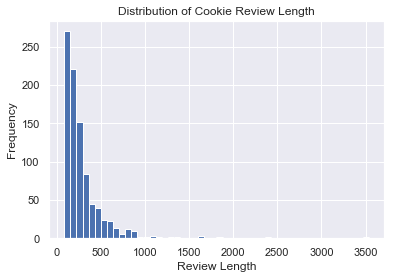

In [7]:
# Import seaborn for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

# This creates a histogram of all of the review lengths
ax = review_lengths.hist(bins=50)
ax.set(xlabel='Review Length', ylabel='Frequency', 
       title='Distribution of Cookie Review Length');

# Natural Language Processing

We're comfortable with the dataset now, so we're ready to dive into some real NLP.

There are usually several steps to the process of cleaning natural language data into a useful form:

1. **Turn text into a meaningful format for analysis**
    * Tokenization: split each document into a list of "tokens", e.g. single words
        - This gives us a basis for numerical comparison across documents, e.g. counting word occurences

2. **Clean the data**
    * Remove: capital letters, punctuation, numbers, very common words (i.e. "stop words") 
    * Stemming, parts of speech tagging
    * Chunking: named entity recognition, compound term extraction



We'll use many of these as we transform our reviews data into a form where it is ready for modeling.

## Tokenization

** Tokenization = splitting raw text into smaller units for processing ** 

These units can be:
* Words 
* Sentences
* Characters
* N-grams: 2 or more word or character pairs, e.g. ('baseball','bat) 

The NLTK library makes some common tokenization tasks easy. Let's say you wanted to break this sentence (which we'll use as our example sentence throughout) into words that are useful for modeling:

> "Hi Mr. Smith! I’m going to buy some vegetables (tomatoes and cucumbers) from the store. Should I pick up 2lbs of black-eyed peas as well?"

How would you do it?

A naive way:

In [8]:
from nltk.tokenize import word_tokenize
my_text = "Hi Mr. Smith, hi! I’m going to buy some vegetables (tomatoes and cucumbers) from the store. Should I pick up 2lbs of black-eyed peas as well?"
print(word_tokenize(my_text))

['Hi', 'Mr.', 'Smith', ',', 'hi', '!', 'I', '’', 'm', 'going', 'to', 'buy', 'some', 'vegetables', '(', 'tomatoes', 'and', 'cucumbers', ')', 'from', 'the', 'store', '.', 'Should', 'I', 'pick', 'up', '2lbs', 'of', 'black-eyed', 'peas', 'as', 'well', '?']


What are the problems with this? To answer this question, let's briefly cover how we'd use these as features in a model:

### Natural language features in machine learning

In [9]:
import pandas as pd
text_df = pd.DataFrame(data=[my_text], index=[0])

In [10]:
for token in word_tokenize(my_text):
    text_df[token] = 1

In [11]:
text_df

,0,Hi,Mr.,Smith,",",hi,!,I,’,m,...,Should,pick,up,2lbs,of,black-eyed,peas,as,well,?
0,"Hi Mr. Smith, hi! I’m going to buy some vegeta...",1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


Essentially, we're going to create features for whether each of these words is present in each review. In NLP terminology, each row of our dataset will be a **document** (review), and each column will be a **term** (occurence of a word or other token).   

Here's another example of how we could add term features for every _bigram_ in the data: 

In [12]:
from nltk.util import ngrams
my_words = word_tokenize(my_text) # This is the list of all words
twograms = list(ngrams(my_words,2)) # This is for two-word combos, but can pick any n
print(twograms)

[('Hi', 'Mr.'), ('Mr.', 'Smith'), ('Smith', ','), (',', 'hi'), ('hi', '!'), ('!', 'I'), ('I', '’'), ('’', 'm'), ('m', 'going'), ('going', 'to'), ('to', 'buy'), ('buy', 'some'), ('some', 'vegetables'), ('vegetables', '('), ('(', 'tomatoes'), ('tomatoes', 'and'), ('and', 'cucumbers'), ('cucumbers', ')'), (')', 'from'), ('from', 'the'), ('the', 'store'), ('store', '.'), ('.', 'Should'), ('Should', 'I'), ('I', 'pick'), ('pick', 'up'), ('up', '2lbs'), ('2lbs', 'of'), ('of', 'black-eyed'), ('black-eyed', 'peas'), ('peas', 'as'), ('as', 'well'), ('well', '?')]


In [13]:
for two_gram in twograms:
    text_df[two_gram] = 1

In [14]:
text_df

,0,Hi,Mr.,Smith,",",hi,!,I,’,m,...,"(Should, I)","(I, pick)","(pick, up)","(up, 2lbs)","(2lbs, of)","(of, black-eyed)","(black-eyed, peas)","(peas, as)","(as, well)","(well, ?)"
0,"Hi Mr. Smith, hi! I’m going to buy some vegeta...",1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


### Bag of words vs. TF-IDF

This approach - looking at whether certain words or bigrams are present in a text document - is known as a **bag of words** approach.

The other approach is one you may have heard of: **TF-IDF** or **Term Frequency-Inverse Document Frequency**. We will discuss this in more detail later; suffice it to say, here we would look at how common a word is in a document _relative to how common it is overall_, so that words that are common in _all_ documents like "the" are not given too much weight.

Now: given the level of cleaning we've done and the features we've generated: if we created these features for every review in our "cookies" dataset, would the features be likely to help us in predicting the review's rating?

In [15]:
text_df

,0,Hi,Mr.,Smith,",",hi,!,I,’,m,...,"(Should, I)","(I, pick)","(pick, up)","(up, 2lbs)","(2lbs, of)","(of, black-eyed)","(black-eyed, peas)","(peas, as)","(as, well)","(well, ?)"
0,"Hi Mr. Smith, hi! I’m going to buy some vegeta...",1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


These features will give us a lot of useful information about the reviews' content, **but notice that some of our tokens are probably useless**:

* Punctuation marks like !
* Repeat tokens from case differences: "Hi" and "hi"  
* Specific numerical quantities like "2lbs"
* Extremely common words like "to", "the"

Additionally, once we tokenize many documents we'll likely get different tokens for different forms of the same word, e.g. "run" vs. "running", "runs", "ran". We'll want to standardize these different forms into one token. 

We'd like to clean up these 5 types of extraneous tokens to get a smaller and more impactful feature set. We'll see how to do this for each type below.

## Removing punctuation

First lets remove punctuation:

We'll do this by leveraging the ```str.maketrans``` function, which gives us a dictionary mapping every punctuation character to the empty string. We can then apply this mapping to our text by using ```translate```. 

In [16]:
import string

remove_punct = str.maketrans('', '', string.punctuation)
clean_text_1 = my_text.translate(remove_punct)
clean_text_1

'Hi Mr Smith hi I’m going to buy some vegetables tomatoes and cucumbers from the store Should I pick up 2lbs of blackeyed peas as well'

## Exercise:

Here's an example review from the dataset:

In [17]:
example_review = data.iloc[1,2]
print(example_review)

Quaker Soft Baked Oatmeal Cookies with raisins are a delicious treat, great for anytime of day.  For example:<br /><br />--at breakfast, I had one with a large banana and a cup of coffee, and felt I'd had a relatively "healthy" start to the day.<br /><br />--the next day at lunch, following a tuna sandwich, I had one with a glass of milk, and was satisfied enough to not need a snack before dinner at 6:30.<br /><br />--the following night, after dinner, I had one with the remainder of my glass of wine. (Delicious!) And again, didn't feel the need to snack later in the evening.<br /><br />Each cookie is individually packaged, and their texture is soft and moist, with just the right amount of sweetness. Natural flavors used in the making are Cinnamon and All Spice.  These flavorings give the cookies a real old-fashioned, homemade taste.<br /><br />Nutritionally, the cookies have 170 calories each, 1.5g saturated fat, 150 mg sodium, and 12g sugar. They also have 2g of protein, and contain 

Remove punctuation from it and store the result in a variable called `example_review_punct`.

**Bonus:** Wrap this in a function called `remove_punct` that takes in a string and removes punctuation.

In [18]:
# Your code here


## Lowercase

The next thing we might want to do is make all the text lowercase, which is easy to do with the ```lower``` function.

In [19]:
clean_text_2 = clean_text_1.lower()
clean_text_2

'hi mr smith hi i’m going to buy some vegetables tomatoes and cucumbers from the store should i pick up 2lbs of blackeyed peas as well'

## Removing numbers

For our third cleaning step, we want to remove numbers from the text. Similarly to how we removed punctuation, we can use the ```translate``` function.

In [20]:
from string import digits

digits

'0123456789'

In [21]:
remove_digits = str.maketrans('', '', digits)
clean_text_3 = clean_text_2.translate(remove_digits)
clean_text_3

'hi mr smith hi i’m going to buy some vegetables tomatoes and cucumbers from the store should i pick up lbs of blackeyed peas as well'

Now if we word tokenize this, we get a much cleaner result:

In [22]:
clean_tokens = word_tokenize(clean_text_3)
print(clean_tokens)

['hi', 'mr', 'smith', 'hi', 'i', '’', 'm', 'going', 'to', 'buy', 'some', 'vegetables', 'tomatoes', 'and', 'cucumbers', 'from', 'the', 'store', 'should', 'i', 'pick', 'up', 'lbs', 'of', 'blackeyed', 'peas', 'as', 'well']


### Exercise

Combining the two cleaning steps from above:

* Make each word in the review lowercase
* Remove numbers

Then, word tokenize the string into a list called `example_review_clean`. 

**Bonus:** Wrap this in a function called `lower_and_remove_numbers` that takes in a string and turns the words to lowercase, removes the numbers, and performs word tokenization.

In [23]:
# Your code here


## Stop words

Our tokens are clean now, but we haven't yet addressed the problem of extremely common words, or **stop words**.

#### Why care about stop words?

What is the most common word in this sentence:

> "Hi Mr. Smith! I’m going to buy some vegetables (tomatoes and cucumbers) from the store. Should I pick up 2lbs of black-eyed peas as well?"

Turns out it is "some". 

**Is the fact that the word "some" appears in this review very informative?** Probably not! When we build a machine learning model, we would prefer to exclude word features that just take up space without giving us any predictive value.

Luckily, "some" is an example of a stop word, and NLTK has a way to deal with it in the form of a collection of stopwords:

In [24]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

clean_tokens_stop = [y for y in clean_tokens if y not in stop_words]

In [25]:
print(clean_tokens_stop)

['hi', 'mr', 'smith', 'hi', '’', 'going', 'buy', 'vegetables', 'tomatoes', 'cucumbers', 'store', 'pick', 'lbs', 'blackeyed', 'peas', 'well']


Looking even better now!

If you're curious about what all the stopwords in this collection are, here they are:

In [26]:
from nltk.corpus import stopwords
print(set(stopwords.words('english')))

{'what', 'about', 'any', 'yourself', 'it', 'those', 'my', 'but', 'to', 'when', 'off', 'himself', 'how', "shouldn't", 'so', "that'll", 'aren', "mightn't", "you've", 'ma', 'itself', 'just', 'ain', 'by', "wouldn't", 'during', 'd', "doesn't", "weren't", "it's", 'hasn', 'didn', "haven't", 'no', "hasn't", "needn't", 'this', 'between', 'be', "you'll", 'further', 'and', 'more', 'who', 'in', 'herself', 'her', 'because', 'again', 'doesn', 'which', 'couldn', 'as', 'now', 'hadn', 'they', 'where', 'y', 'theirs', "isn't", 'very', 'over', 'few', 'don', 'did', 'above', 'will', 'nor', 'then', 'with', 'own', 'from', 'being', 'down', 'she', 'through', 'm', 'before', 'here', 'mustn', 'does', 't', 'll', 'are', 'shouldn', 'into', 'than', 'is', 'we', 'your', 'wasn', 'our', 'against', 'after', 'such', 's', 'themselves', 'while', 'if', 'ours', 'o', 'wouldn', 'an', 'a', 'for', "aren't", "mustn't", 'until', 'myself', 'on', 'weren', 'were', 'some', "shan't", 'ourselves', 'too', 'once', 'his', 'its', 'can', 'the',

### Exercise

Remove stop words from `example_review_clean`, and store the result in a list called `example_review_stop`.

**Bonus:** Wrap this in a function called `remove_stop_words` that takes in a string of tokens of words and removes the stop words.

In [27]:
# Your code here



### Stemming

What about go vs. going? Should those be considered differently in our model? Probably not. Enter stemming and lemmatization:

![](http://soph.info/metis/blackrock_python/stem_lem.png)

In this notebook we'll focus on stemming. There are a number of stemming options built into nltk, including Lancaster and Snowball stemming. For now, we won't worry about the differences between these two and will just see how they are applied.

First, here's an example of how stemming can standardize different forms of the same root word:

In [28]:
from nltk.stem.lancaster import LancasterStemmer
stemmer = LancasterStemmer()
# Try some stems
print('drive: {}'.format(stemmer.stem('drive')))
print('drives: {}'.format(stemmer.stem('drives')))
print('driver: {}'.format(stemmer.stem('driver')))
print('drivers: {}'.format(stemmer.stem('drivers')))
print('driven: {}'.format(stemmer.stem('driven')))

drive: driv
drives: driv
driver: driv
drivers: driv
driven: driv


Now let's see how we can stem our actual text tokens.

In [29]:
# Perform stemming, which removes alternate word endings without knowledge of the context
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer('english')
clean_tokens_stem = [stemmer.stem(y) for y in clean_tokens_stop]

In [30]:
print(clean_tokens_stem)

['hi', 'mr', 'smith', 'hi', '’', 'go', 'buy', 'veget', 'tomato', 'cucumb', 'store', 'pick', 'lbs', 'blackey', 'pea', 'well']


### Exercise

Perform stemming on `example_review_stop`, and store the result in a list called `example_review_stem`.

**Bonus:** Wrap this in a function called `stem_list` that takes in a string of tokens of words and performs stemming on each word.

In [31]:
# Your code here



Great, our tokens look much cleaner now than what we started with! At this point, we've worked through the most commonly used processing steps in NLP applications in Machine Learning. There are many other common tasks such as part of speech tagging, but these don't have as direct an application to extracting valuable information from data for modeling.

### Exercise

The code below will take a string called `input_string` and turn it into a DataFrame with unigrams and bigrams as features:

```python
def unigrams_bigrams(input_string):
    text_df = pd.DataFrame(data=[input_string], index=[0])
    for token in word_tokenize(input_string):
        text_df[token] = 1

    my_words = word_tokenize(input_string) 
    twograms = list(ngrams(my_words,2)) 

    for two_gram in twograms:
        text_df[two_gram] = 1
            
    return text_df
```    

1. Run this code with our original review string - `example_review` and see how many features result.

2. Then, run this code with our "cleaned" review string - `example_review_stem` - and see how many features result.

Which has more features? Why? Which do you think will be more effective and interpretable as input to a machine learning model?

In [32]:
# Your code here



### Discussion:

What other preprocessing could be helpful? What other features might we be able to extract that could help us distinguish between the reviews?

### Preprocessing the cookies review data

Now that we've learned these 5 key text preprocessing techniques, let's practice them by applying them to the cookies review data in a series of exercises. Remember to reference the steps above to figure out how to solve each part! To make it easier, we've copied the old relevant code next to each exercise.

In [33]:
data.head()

,user_id,stars,reviews
0,A368Z46FIKHSEZ,5,I love these cookies! Not only are they healt...
1,A1JAPP1CXRG57A,5,Quaker Soft Baked Oatmeal Cookies with raisins...
2,A2Z9JNXPIEL2B9,5,I am usually not a huge fan of oatmeal cookies...
3,A31CYJQO3FL586,5,I participated in a product review that includ...
4,A2KXQ2EKFF3K2G,5,My kids loved these. I was very pleased to giv...


We'll do the first together. Note the handy use of ```data['reviews'].str``` to apply a string-based function to every record in the reviews column.

As a reminder, the code used to clean the punctuation previously was:

```python
remove_punct = str.maketrans('', '', string.punctuation)
clean_text_1 = my_text.translate(remove_punct)
clean_text_1
```

In [34]:
# EXERCISE 1: create a new pandas series that stores 
# all of the cookie reviews with punctuation removed.  

remove_punct = str.maketrans('', '', string.punctuation)
reviews_clean_1 = data['reviews'].str.translate(remove_punct)
reviews_clean_1.head()

0    I love these cookies  Not only are they health...
1    Quaker Soft Baked Oatmeal Cookies with raisins...
2    I am usually not a huge fan of oatmeal cookies...
3    I participated in a product review that includ...
4    My kids loved these I was very pleased to give...
Name: reviews, dtype: object

In [35]:
# EXERCISE 2: take the result of ex 1 (punctuation removed),
# and convert the reviews to lower case and remove numbers. Use .str
# like in the exercise above


PREVIOUS CODE:

```python
clean_text_2 = clean_text_1.lower()
clean_text_2

remove_digits = str.maketrans('', '', digits)
clean_text_3 = clean_text_2.translate(remove_digits)
clean_text_3
```

In [36]:
# EXERCISE 3: tokenize the result of ex 2  

# HINT: you can apply a function like word_tokenize to each entry 
# in a pandas series by calling .map(function_name) on the series


PREVIOUS CODE:

```python    
clean_tokens = word_tokenize(clean_text_3)
print(clean_tokens)
```

In [37]:
# EXERCISE 4: take the result of ex 3 (list of tokens) and 
# remove stop words

# HINT: turn the previous code into a function that removes stop words 
# from 1 token list, then use map to apply it to all 
# collections of tokens.


PREVIOUS CODE:

```python    
stop_words = stopwords.words('english')
clean_tokens_stop = [y for y in clean_tokens if y not in stop_words]
```

In [38]:
# EXERCISE 5: take the result of ex 4 (list of stopword removed tokens) 
# and stem all the tokens using the SnowballStemmer

# HINT: same approach as exercise 4


PREVIOUS CODE:

```python
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer('english')
clean_tokens_stem = [stemmer.stem(y) for y in clean_tokens_stop]
```

Nice, now we've gotten to a list of preprocessed tokens for the entire set of reviews. Since at this point we're comfortable with NLP preprocessing. Now's let's show how these NLP techniques can help us predict things about these reviews using machine learning.

## Machine Learning

When building machine learning models, the very first thing we should do is to separate the data into a **training set** and a **test set**. This way, we can fit a model to the training set, and evaluate how well it might perform on new, unseen data by scoring it on the test set. 

In [39]:
from sklearn.model_selection import train_test_split

X, y = data.reviews, data.stars
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.3, random_state=3)

In [40]:
X_train.shape, y_train.shape # number of reviews we train on

((639,), (639,))

In [41]:
X_test.shape, y_test.shape # number of reviews we test on

((274,), (274,))

#### CountVectorizer

Now that we've separated our data into train and test, let's try to understand how we can turn word tokens into numerical features. Remember the simple example we saw earlier for our toy sentence: 

In [42]:
text_df

,0,Hi,Mr.,Smith,",",hi,!,I,’,m,...,"(Should, I)","(I, pick)","(pick, up)","(up, 2lbs)","(2lbs, of)","(of, black-eyed)","(black-eyed, peas)","(peas, as)","(as, well)","(well, ?)"
0,"Hi Mr. Smith, hi! I’m going to buy some vegeta...",1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


Here we simply have 1 column for each term, with a 1 marking that the term has occured in this document.

**CountVectorizer** is only a bit more complicated than this. CountVectorizer collects a **vocabulary** of all of the tokens that occur across all documents, creating a column for each vocabulary term.

For each document (row), the value stored in the term column will be the **number of times that term occurs in the document**. So in essence we're just counting how many times a word occurs in each review. Luckily, sci-kit learn has functionality to do this for us automatically, even handling tokenization for us!

Here is a nice example on a small collection of 5 documents:

In [43]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = ['The weather is hot under the sun',
          'I make my hot chocolate with milk',
          'One hot encoding',
          'I will have a chai latte with milk',
          'There is a hot sale today']

# create the document-term matrix with count vectorizer
cv = CountVectorizer()
X = cv.fit_transform(corpus).toarray()
dt = pd.DataFrame(X, columns=cv.get_feature_names())
dt

,chai,chocolate,encoding,have,hot,is,latte,make,milk,my,one,sale,sun,the,there,today,under,weather,will,with
0,0,0,0,0,1,1,0,0,0,0,0,0,1,2,0,0,1,1,0,0
1,0,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0


Note that since most of the vocabulary words do not occur in any given document, most of the feature column values are 0.

#### Applying CountVectorizer to the cookies review data

With that introduction to CountVectorizer, let's run it on our real dataset. We already have a train and test split, so we just need to run the CountVectorizer transformations to extract features before fitting and scoring a model.

We'll use the simple **Naive Bayes** model, a commonly used benchmark model for text problems.

In [44]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()

# get training data vocabulary and extract term count column results 
X_train_cv = cv.fit_transform(X_train)

# use training data vocabulary to extract term count column results 
X_test_cv  = cv.transform(X_test)

In [45]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

nb.fit(X_train_cv, y_train)
nb.score(X_test_cv, y_test) # accuracy score

0.7262773722627737

Decent, more than 72% accurate just using a naive countvectorizer.

To bring together the preprocessing we learned earlier with our machine learning, we'll enhance the CountVectorizer we're using by improving its tokenization. We'll use all the steps we learned earlier.

It turns out that we can do this by defining a **custom tokenizer function** as below. This function will take a text string as input, cleaning and tokenizing it as desired to produce a token list as output. To make CountVectorizer use this tokenizer, all we have to do is pass the function to the argument ```tokenizer``` when creating our vectorizer. That tells it to use our function to tokenize every document.

In [46]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

def custom_tokenizer(text):

    # remove punctuation
    remove_punct = str.maketrans('', '', string.punctuation)
    text = text.translate(remove_punct)

    # remove digits and convert to lower case
    remove_digits = str.maketrans('', '', string.digits)
    text = text.lower().translate(remove_digits)

    # tokenize
    tokens = word_tokenize(text)

    # remove stop words
    stop_words = stopwords.words('english')
    tokens_stop = [y for y in tokens if y not in stop_words]

    # stem
    stemmer = SnowballStemmer('english')
    tokens_stem = [stemmer.stem(y) for y in tokens_stop] 

    return tokens_stem

In [47]:
# countvectorizing and training
cv = CountVectorizer(tokenizer=custom_tokenizer)

X_train_cv = cv.fit_transform(X_train)
X_test_cv  = cv.transform(X_test)

nb = MultinomialNB()

nb.fit(X_train_cv, y_train)
nb.score(X_test_cv, y_test)

0.7299270072992701

With our custom tokenizer, the accuracy result is a bit better.

But it's possible that we may have been overzealous in our cleaning, removing some information that's actually useful for predicting the rating. 

In [48]:
# EXERCISE 6: Try making some adjustments to our custom tokenizer above 
# and rerunning the countvectorize + train step above
# to see if you can improve the score. 

# What if we skip the stemming stage at the end? Try removing/commenting
# out the stemming steps and/or just returning tokens_stop

In [49]:
# EXERCISE 7: Let's explore the options built into CountVectorizer a
# bit more. Open up the documentation by running the cell below, 
# and read about the ngram_range argument.

# Uncomment the code below and adjust it to use both 1-gram (single word) 
# and 2-gram tokens. Are the test results better or worse than before?

In [50]:
CountVectorizer?

STARTER CODE:

```python
cv = CountVectorizer(ngram_range=FILL IN)

X_train_cv = cv.fit_transform(X_train)
X_test_cv  = cv.transform(X_test)

nb = MultinomialNB()

nb.fit(X_train_cv, y_train)
nb.score(X_test_cv, y_test)
```

## Tf-idf Vectorizer

To wrap up, we'll briefly explore a more advanced term feature extraction technique: **Term Frequency - Inverse Document Frequency**.

Though it sounds fancy, it's really only slightly more complicated than CountVectorizer. We still tokenize and extract term counts exactly as before, but adjust the term counts to normalize for how common terms are across documents.

For example, the word "cookie" likely occurs in very many reviews, while the word "delicious" is probably more rare. Accordingly, when we see "cookie" we should downweight it for being common and uninformative, giving "delicious" more relative importance because its occurence is more informative. 

![](http://soph.info/metis/blackrock_python/tf_idf_2.png)

![](http://soph.info/metis/blackrock_python/tf_idf_1.png)

#### Illustration of `TfidfVectorizer`

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = ['The weather is hot under the sun',
          'I make my hot chocolate with milk',
          'One hot encoding',
          'I will have a chai latte with milk',
          'There is a hot sale today']

# create the document-term matrix with count vectorizer
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()
dt = pd.DataFrame(X, columns=tfidf.get_feature_names())
dt

,chai,chocolate,encoding,have,hot,is,latte,make,milk,my,one,sale,sun,the,there,today,under,weather,will,with
0,0.000000,0.000000,0.0000,0.000000,0.199581,0.285811,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.354256,0.708511,0.000000,0.000000,0.354256,0.354256,0.000000,0.000000
1,0.000000,0.465281,0.0000,0.000000,0.262131,0.000000,0.000000,0.465281,0.375386,0.465281,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.375386
2,0.000000,0.000000,0.6569,0.000000,0.370086,0.000000,0.000000,0.000000,0.000000,0.000000,0.6569,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.434297,0.000000,0.0000,0.434297,0.000000,0.000000,0.434297,0.000000,0.350388,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.434297,0.350388
4,0.000000,0.000000,0.0000,0.000000,0.282814,0.405004,0.000000,0.000000,0.000000,0.000000,0.0000,0.501992,0.000000,0.000000,0.501992,0.501992,0.000000,0.000000,0.000000,0.000000


Similar to CountVectorizer, we can do this automatically using sklearn. Note that the only real difference between this code and what we already did is that we use TfidfVectorizer instead of CountVectorizer - very convenient!

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

nb = MultinomialNB()

nb.fit(X_train_tfidf, y_train)
nb.score(X_test_tfidf, y_test)

0.7007299270072993

In this case, Tf-idf Vectorizer does not seem to work better than the simpler CountVectorizer. In many cases it does work better, but this reinforces an important lesson in machine learning: there's no such thing as a model or feature type that's always superior. Sometimes simpler is better! 